In [2]:
import numpy as np, matplotlib.pyplot as plt
import scipy.optimize as optimize
import matplotlib as mpl
from astropy.io import ascii as asc
from astropy.table import Table
from analysis.composite_errors import composite_errors

FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'
CUTOFF_SIGMA = 4.0
CUTOFF_MASS = 6.0

In [3]:
# reading in data generated by EBV_corrections.py
corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',guess=False,
                Reader=asc.FixedWidthTwoLine)
zspec0 = np.array(corr_tbl['zspec0'])
no_spectra  = np.where((zspec0 <= 0) | (zspec0 > 9))[0]
yes_spectra = np.where((zspec0 >= 0) & (zspec0 < 9))[0]

stlr_mass = np.array(corr_tbl['stlr_mass'])
filts = np.array(corr_tbl['filt'])
sfr = np.array(corr_tbl['met_dep_sfr'])
dust_corr_factor = np.array(corr_tbl['dust_corr_factor'])
filt_corr_factor = np.array(corr_tbl['filt_corr_factor'])
nii_ha_corr_factor = np.array(corr_tbl['nii_ha_corr_factor'])
corr_sfrs = sfr+filt_corr_factor+nii_ha_corr_factor+dust_corr_factor

# defining a flux sigma and mass cutoff
good_sig_iis = np.where((corr_tbl['flux_sigma'] >= CUTOFF_SIGMA) & (stlr_mass >= CUTOFF_MASS))[0]
n = len(good_sig_iis)

In [4]:
sigmas = corr_tbl['meas_errs'][good_sig_iis].data
mass = stlr_mass[good_sig_iis]
sfrs = corr_sfrs[good_sig_iis]

z_sp = zspec0[good_sig_iis]
badz_iis = np.array([x for x in range(len(z_sp)) if z_sp[x] < 0 or z_sp[x] > 9])
filt_lambda_list = {'NB704':7045.0, 'NB711':7126.0, 'NB816':8152.0, 'NB921':9193.0, 'NB973':9749.0}
ffs = filts[good_sig_iis]
for ff in filt_lambda_list.keys():
    badf_match = np.where(ffs[badz_iis] == ff)[0]
    z_sp[badz_iis[badf_match]] = (filt_lambda_list[ff]/6562.8) - 1
    
mz_data = np.vstack([mass, z_sp]).T

In [5]:
eqn_str = r'$\log(SFR) = \alpha \log(M) + \beta z + \gamma$'
def func(data, a, b, c):
    return a*data[:,0] + b*data[:,1] + c

### the plot

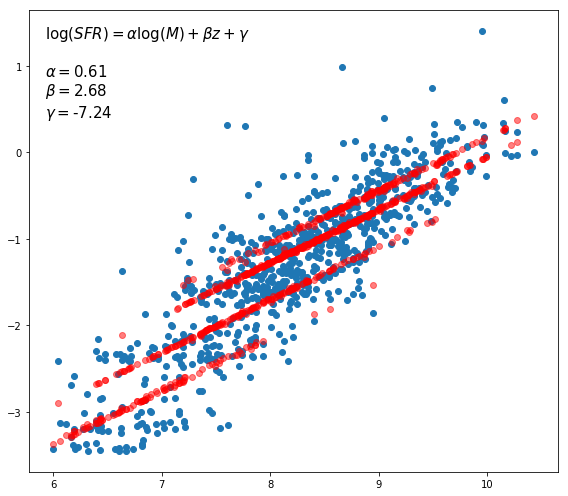

In [6]:
f, ax = plt.subplots()
# axarr = np.ndarray.flatten(axes)
f.set_size_inches(8,7)

ax.plot(mass, sfrs, 'o')
params00, pcov = optimize.curve_fit(func, mz_data, sfrs)
perr = np.sqrt(np.diag(pcov))
ax.plot(mass, func(mz_data, *params00), 'ro', alpha=0.5)
ax.text(0.03,0.97,eqn_str+
    '\n\n'+r'$\alpha=$'+'%.2f'%params00[0]+ #r'$\pm$'+'%.3f'%perr[0]+
    '\n'+r'$\beta=$'+'%.2f'%params00[1]+ #r'$\pm$'+'%.3f'%perr[1]+
    '\n'+r'$\gamma=$'+'%.2f'%params00[2], #+r'$\pm$'+'%.3f'%perr[2],
    transform=ax.transAxes,fontsize=15,ha='left',va='top')

plt.tight_layout()
plt.show()

## monte carlo'ing

In [7]:
from astropy.stats import sigma_clip
from scipy import interpolate

def confidence(x):
    xc = sigma_clip(x, sigma=3, iters=40)
    nbins = int(np.ceil((max(x)-min(x))/(0.02*np.std(xc))))
    
    hist, bin_edges = np.histogram(x, bins=nbins)
    size = (np.max(x)-np.min(x))/nbins
    max0 = max(hist)
    #print bin_edges[np.where(hist == max0)[0][0]]
    levels = range(int(max0), -1, -1)
    #print levels

    percent = np.zeros(len(levels))
    for jj in range(int(max0)+1):
        temp = []
        level = max0 - jj
        ugh = np.where(hist > level)
        percent[jj] = (np.sum(hist[ugh])/(np.sum(hist)+0.0))
        #print level, np.sum(temp)

    #print percent
    f = interpolate.interp1d(percent, levels)
    sigs = [0.68269]

    sig_levels = f(sigs)
    #print sig_levels

    idx_max = np.where(hist == np.max(hist))[0]

    left = np.arange(idx_max[0]+1)
    right = np.array(np.arange(idx_max[-1], len(hist)))

    f_left = interpolate.interp1d(hist[left], left)
    f_right = interpolate.interp1d(hist[right], right)

    low1 = f_left(sig_levels)
    high1 = f_right(sig_levels)

    low = bin_edges[0]+low1*size
    high = bin_edges[0]+high1*size
    
#     n,bins,patches = plt.hist(x,nbins, facecolor='green',align='mid')
#     plt.plot((np.min(x),np.max(x)),(sig_levels, sig_levels))
#     plt.show()

    low_limit = np.median(x)-low
    high_limit = high-np.median(x)

    return low_limit, high_limit

(1) Randomize a mainseq sample of galaxies 

a. iterate over filters

b. choose *num_filt* number of *filt* galaxies

c. draw from a 1D distribution of mass, SFR based off of table 3/figure 8. do this the appropriate number of times *N* per relevant 'mass bin' 

d. store all the information in mass,SFR,z arrays

(2) Fit  \log(SFR) = \alpha \log(M) + \beta z + \gamma  to this sample

(3) Repeat this ~a thousand or so times (and store all the values of \alpha, \beta, and \gamma)

(4) Call contours.confidence(x) on these arrays of \alpha, \beta, and \gamma to get my parameter estimations 

In [8]:
mbins0 = np.arange(6.25, 10.75, .5)

len(sfrs), len(mass), len(z_sp)

(777, 777, 777)

In [9]:
np.random.seed(12376)

alpha_arr = np.array([])
beta_arr = np.array([])
gamma_arr = np.array([])

for i in range(1000):
    if i%100==0: print i
    m_arr = np.array([])
    s_arr = np.array([])
    z_arr = np.array([])

    for idx, ff in enumerate(['NB7', 'NB816', 'NB921', 'NB973']):
        filt_match = np.array([x for x in range(len(ffs)) if ff in ffs[x]])

        m0 = mass[filt_match]
        s0 = sfrs[filt_match]
        z0 = z_sp[filt_match]

        bin_ii = np.digitize(m0, mbins0+0.25)
        for i in set(bin_ii):
            bin_match = np.where(bin_ii == i)[0]
            N = len(bin_match)

            # below: sampling to be changed?
            m = mbins0[i]
    #         m0s = np.random.uniform(m-0.25, m+0.25, N)
            m0s = np.random.choice(m0[bin_match], size=N)
            m_arr = np.append(m_arr, m0s)

            s0s = np.random.choice(s0[bin_match], size=N)
            s_arr = np.append(s_arr, s0s)

            z0s = np.random.choice(z0[bin_match], size=N)
            z_arr = np.append(z_arr, z0s)

    mz_ndarr = np.vstack([m_arr, z_arr]).T

    params, pcov = optimize.curve_fit(func, mz_ndarr, s_arr)
    alpha_arr = np.append(alpha_arr, params[0])
    beta_arr = np.append(beta_arr, params[1])
    gamma_arr = np.append(gamma_arr, params[2])

0
100
200
300
400
500
600
700
800
900


(array([ 0.00482528]), array([ 0.01227862]))
(array([ 0.12785119]), array([ 0.17598262]))
(array([ 0.13095627]), array([ 0.12032196]))


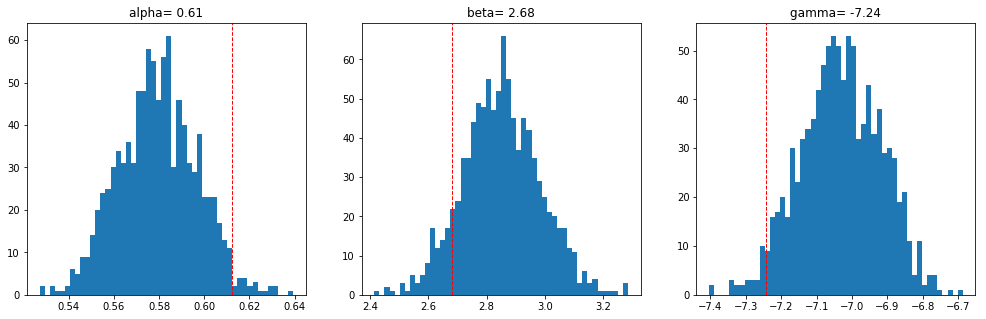

In [10]:
f, axes = plt.subplots(1,3)
for i, ax, const_arr, lbl in zip(range(3), axes, [alpha_arr, beta_arr, gamma_arr], ['alpha', 'beta', 'gamma']):
    ax.hist(const_arr, bins=50)
    ax.axvline(params00[i], c='r', ls='--')
    ax.set_title(lbl+'= %.2f'%params00[i])
    
    print confidence(const_arr)
    
f.set_size_inches(17,5)

## monte carlo'ing attempt #2

In [22]:
np.random.seed(12376)

alpha_arr = np.array([])
beta_arr = np.array([])
gamma_arr = np.array([])

for i in range(10000):
    if i%100==0: print i
    m_arr = np.array([])
    s_arr = np.array([])
    z_arr = np.array([])
    
    iis = np.random.choice(len(sfrs), len(sfrs))
    m_arr = mass[iis]
    s_arr = sfrs[iis]
    z_arr = z_sp[iis]

    mz_ndarr = np.vstack([m_arr, z_arr]).T

    params, pcov = optimize.curve_fit(func, mz_ndarr, s_arr)
    alpha_arr = np.append(alpha_arr, params[0])
    beta_arr = np.append(beta_arr, params[1])
    gamma_arr = np.append(gamma_arr, params[2])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


0.61 (- 0.019, + 0.017)
2.68 (- 0.138, + 0.157)
-7.24 (- 0.138, + 0.126)


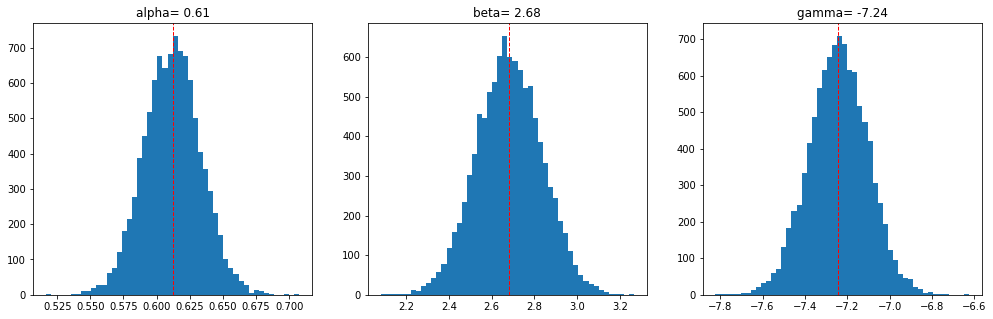

In [27]:
f, axes = plt.subplots(1,3)
for i, ax, const_arr, lbl in zip(range(3), axes, [alpha_arr, beta_arr, gamma_arr], ['alpha', 'beta', 'gamma']):
    ax.hist(const_arr, bins=50)
    ax.axvline(params00[i], c='r', ls='--')
    ax.set_title(lbl+'= %.2f'%params00[i])
    
    print '%.2f'%params00[i], '(- %.3f'%confidence(const_arr)[0]+', + %.3f'%confidence(const_arr)[1]+')'
    
f.set_size_inches(17,5)